# Non-ideal reaction-diffusion systems

In the last notebook you learned the basics of phase separation driven by the competition between entropy (favoring mixing) and non-ideal interactions (favoring demixing). In this notebook you will see how first order reactions can introduce patterns of a certain length scale.

In [1]:
# This notebook requires py-pde in version 0.17.1 or later
# The package can be obtained from https://github.com/zwicker-group/py-pde
# Alternatively, it can be installed via pip or conda

import pde

# plotting functions
import matplotlib.pyplot as plt
import numpy as np

We build upon the last notebook, where the concentration field $c(x,y,t)$ describes the state of the system. But now the dynamics are not given by diffusion only, instead the particles can react as well and we introduce a reactive flux $s$ that describes how many $A$ particles are created $s>0$ or destroyed $s<0$ per unit time. In this case the full dynamics are given by

\begin{align}
    \partial_t c(x,y,t) = M\nabla^2 \mu (x,y,t) + s(x,y,t)
\end{align}

where we assume a constant diffusive mobility $M$.

We assume a simple switch between the two particle types $A\rightleftharpoons B$, where $A\rightarrow B$ proceeds with rate $k_f$ and $B\rightarrow A$ with rate $k_b$. The total change of $A$ particles is then given by $s=-k_fc_A + k_bc_B=-k_fc+k_b(1-c)$, using $c_A=c$ and $c_B=1-c_A$. 

## Reactions in a homogeneous mixture

We neglect diffusion for now and discuss the reactive flux $s$ only.

### Problem 1

For constant $k_f$ and $k_b$, calculate the concentration $c_0$ for which $s(c)=-k_f c+k_b(1-c)$ vanishes. Afterwards plot $s(c)$ for $k_f=1$ and $k_b=0.3k_f$. For a given $c(t=0)$ and use it to explain the dynamics $\partial_t c = -k_f c + k_b(1-c)$.<br>
Then determine the slope $-k$ in terms of $k_f$ and $k_b$ and express $s(c)$ in terms of $k$ and $c_0$.

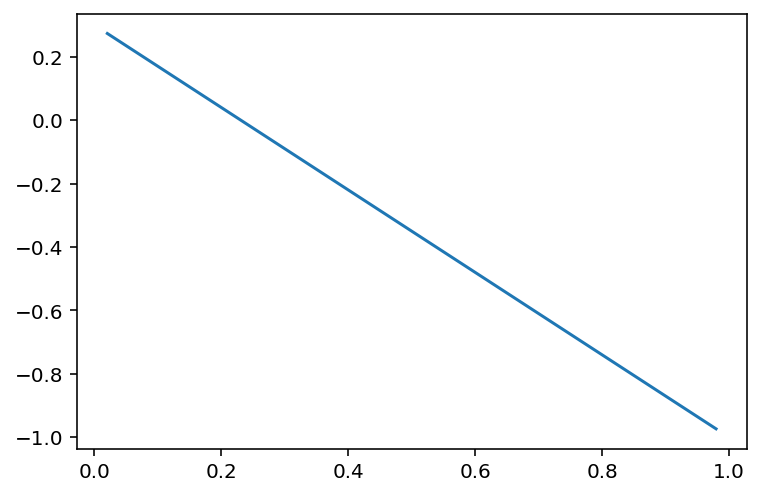

In [2]:
kf = 1
kb = 0.3*kf
c = np.linspace(0, 1)[1:-1]

plt.plot(c,-kf*c+kb*(1-c))

### Solution 1

For $c>c_0$ $s<0$ so $A$ gets destroyed until $c=c_0$, while $A$ is created for $c<c_0$, so $c_0$ is a stable fixpoint.<br>
The slope is $k=k_f+k_b$ and the flux vanishes for $c_0=k_b/(k_f+k_b)$, so $s(c) = -k(c-c_0)$.

## Combining non-ideal diffusion and reaction

We use the free energy density from the last tutorial

\begin{align}
    F = a V \phi^2 ( 1- \phi^2)
\end{align}

which is plotted below for $a=1$.

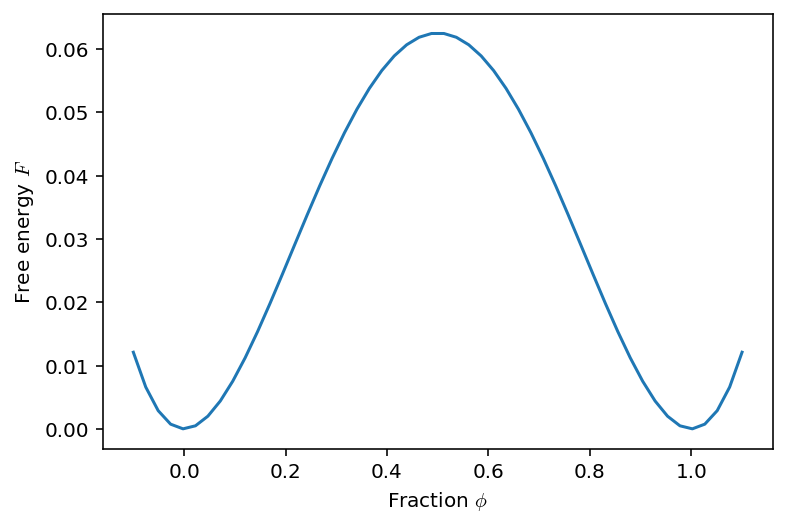

In [3]:
c = np.linspace(-0.1, 1.1)
plt.plot(c, c**2 * (1 - c)**2)
plt.xlabel('Fraction $\phi$')
plt.ylabel(r'Free energy $F$');

### Problem 2

First adjust the right hand side of `pde.PDE` to include chemical reactions $s(c)=-k(c-c_0)$.<br>
Then run the simulation for $k=5\cdot10^{-3}$ and $c_0=0.1$. How does the average concentration develop over time? Why is it different from the case without reactions?

Afterwards find a function that describes the average concentratoin over time $\bar{c}(t)$ in terms of the initial average concentration $\bar{c}(t=0)$ and the reaction parameters $k$ and $c_0$.

In [4]:
# define the partial differential equation
k = 5.e-3
c0 = 0.1

eq = pde.PDE({'c': 'laplace(2 * c * (1 - c) * (1 - 2*c) - laplace(c))'})

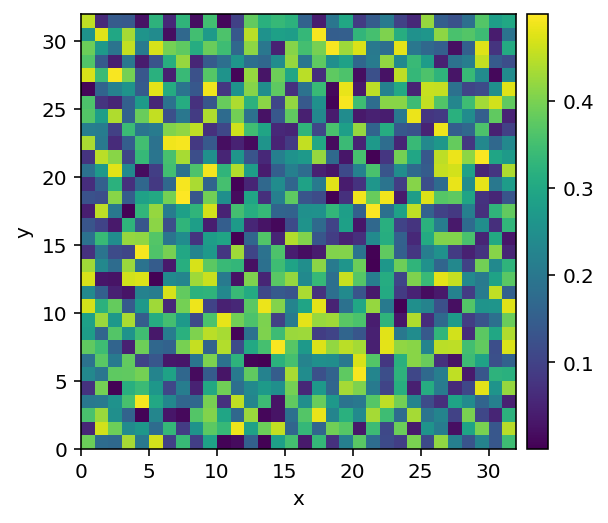

  0%|          | 0/1000.0 [00:00<?, ?it/s]

/Users/dzwicker/user/miniconda3/envs/python3/lib/python3.9/site-packages/numba/core/dispatcher.py:289: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'VersionConflict((scipy 1.8.0 (/Users/dzwicker/user/miniconda3/envs/python3/lib/python3.9/site-packages), Requirement.parse('scipy<=1.6.2,>=0.16')))'.
  entrypoints.init_all()


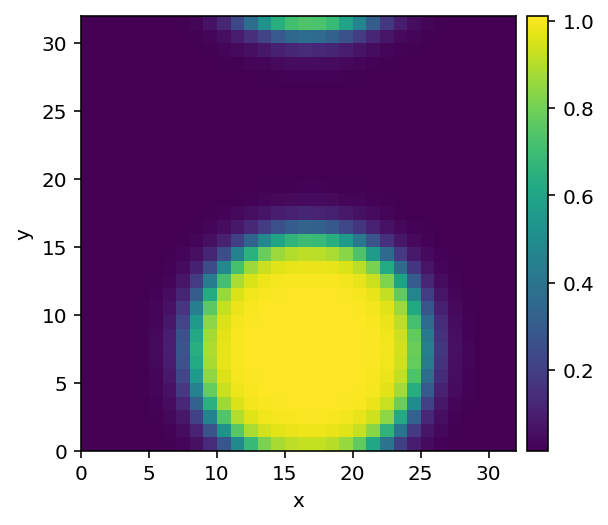

In [5]:
# prepare a random initial state
grid = pde.UnitGrid([32, 32], periodic=True)
initial_state = pde.ScalarField.random_uniform(grid, vmin=0, vmax=0.5)
initial_state.plot();

# simulate the dynamics
storage = pde.MemoryStorage()
final_state = eq.solve(initial_state, t_range=1000, dt=1.e-3, tracker=['progress', storage.tracker(10)])
final_state.plot();

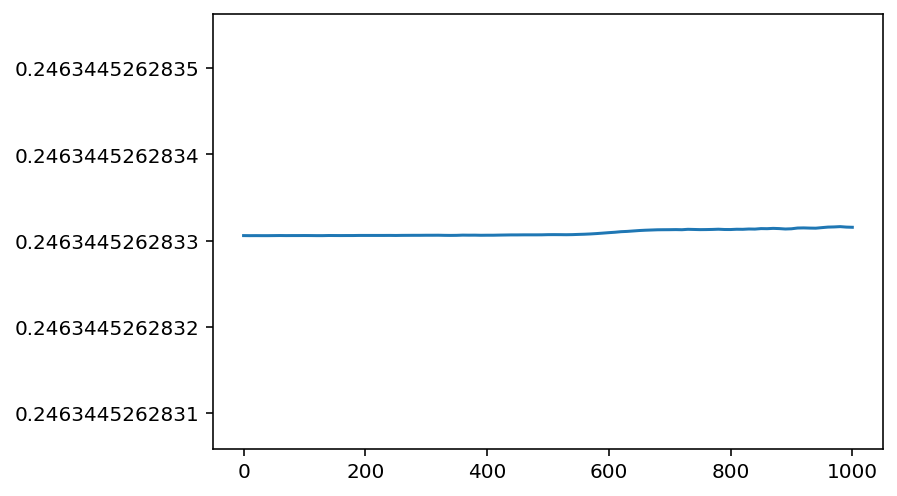

In [6]:
avs = np.zeros(len(storage.data))
for i in range(len(storage.data)):
    avs[i] = np.average(storage.data[i])
ts = np.asarray(storage.times)

plt.plot(ts,avs)
plt.show()
plt.close()

### Solution 2

The average concentration decays exponentially towards $c_0$. Mass is not conserved anymore, because the stable fixed-point for the reaction is $c_0$ independent of the initial average concentration.
The average concentration can be described by $\bar{c}(t)=c_0+(\bar{c}(t=0)-c_0)\exp(-kt)$

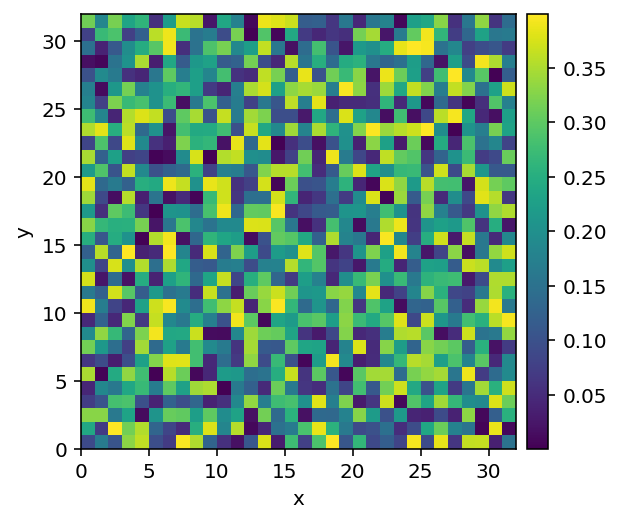

  0%|          | 0/1000.0 [00:00<?, ?it/s]

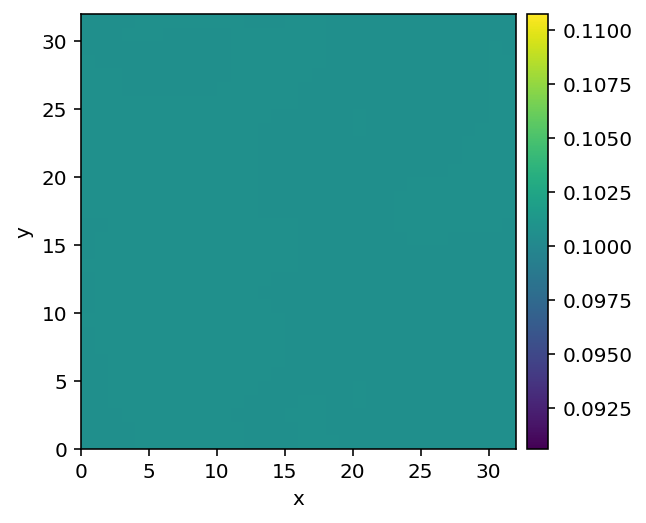

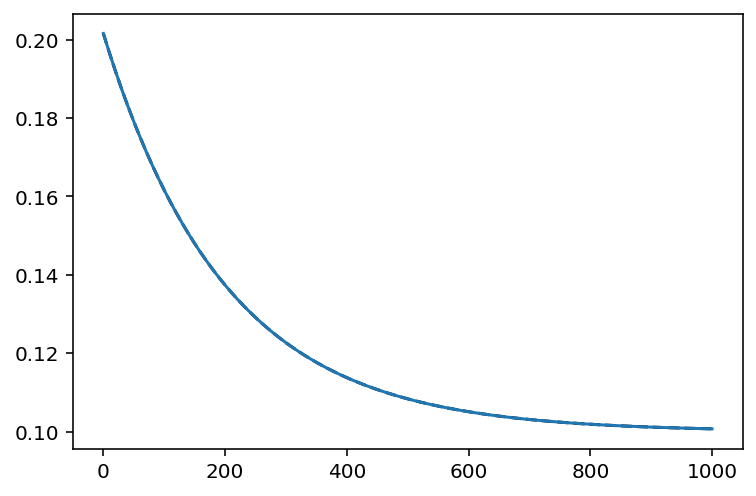

In [7]:
eq2 = pde.PDE({'c': f'laplace(2 * c * (1 - c) * (1 - 2*c) - 2*laplace(c)) - {k} * (c - {c0})'})
eq2.expressions

# prepare a random initial state
grid = pde.UnitGrid([32, 32], periodic=True)
initial_state = pde.ScalarField.random_uniform(grid, vmin=0, vmax=0.4)
initial_state.plot();

# simulate the dynamics
storage = pde.MemoryStorage()
final_state = eq2.solve(initial_state, t_range=1000, dt=1.e-3, tracker=['progress', storage.tracker(10)])
final_state.plot();

avs = np.zeros(len(storage.data))
for i in range(len(storage.data)):
    avs[i] = np.average(storage.data[i])
ts = np.asarray(storage.times)
plt.plot(ts,c0+(avs[0]-c0)*np.exp(-k*ts),ls='--',color='k')
plt.plot(ts,avs)
plt.show()
plt.close()

## Droplets with chemical reactions

For the initial condition and $c_0$ above the system ends up in a homogeneous state with $c(x,y)=c_0$ everywhere. But It is possible to form droplets with chemical reactions as well. For example increasing $c_0$ and the initial average concentration leads to the formation of one stable droplet.

In [8]:
# define the partial differential equation
k = 5.e-3
c0 = 0.25

eq2 = pde.PDE({'c': f'laplace(2 * c * (1 - c) * (1 - 2*c) - 2*laplace(c)) - {k} * (c - {c0})'})
eq2.expressions

{'c': '-0.005*c + laplace(2*c*(c - 1)*(2*c - 1) - 2*laplace(c)) + 0.00125'}

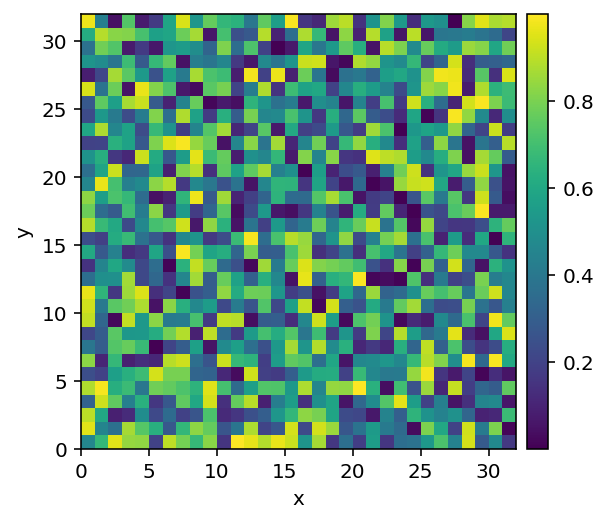

  0%|          | 0/1000.0 [00:00<?, ?it/s]

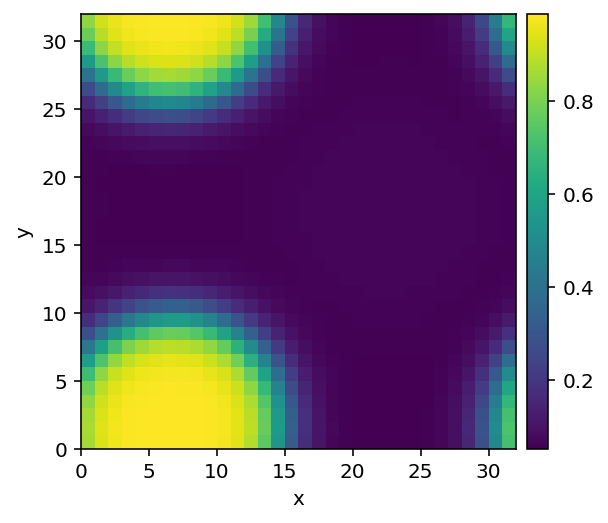

In [9]:
# prepare a random initial state
grid = pde.UnitGrid([32, 32], periodic=True)
initial_state = pde.ScalarField.random_uniform(grid, vmin=0, vmax=1.)
initial_state.plot();

# simulate the dynamics
storage = pde.MemoryStorage()
final_state = eq2.solve(initial_state, t_range=1000, dt=1.e-3, tracker=['progress', storage.tracker(10)])
final_state.plot();

### Problem 3
Plot the time evolution of the average concentration, is it qualitatively different from the homogeneous case?<br>
Looking at the final state, how would the reaction rate inside and outside the droplet look like?<br>
Using `pde.ScalarField(grid,data=?)` function, plot the reaction rate corresponding to the final state of your simulation.

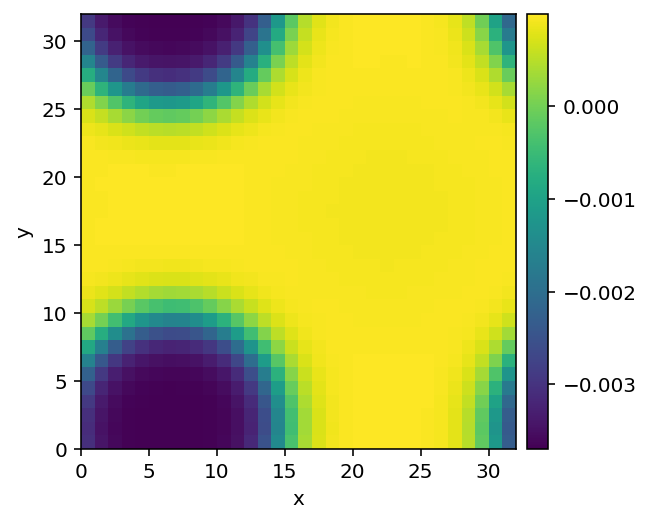

In [10]:
react = pde.ScalarField(grid, data=-k*(final_state.data-c0))
react.plot()

### Solution 3
It is qualitatively the same as in the homogeneous case, a exponential decay to $c_0$.<br>
The reaction is strongly negative inside the droplet and positive or zero outside.

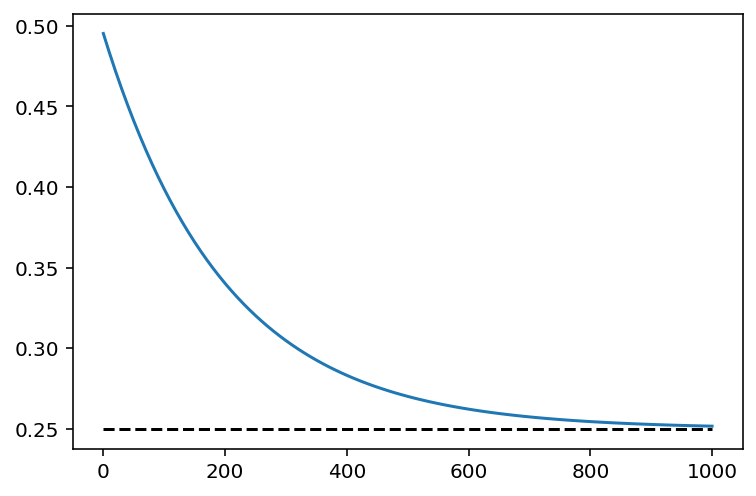

In [11]:
avs = np.zeros(len(storage.data))
for i in range(len(storage.data)):
    avs[i] = np.average(storage.data[i])
ts = np.asarray(storage.times)
plt.plot([0,1000],[c0,c0],color='k',ls='--')
plt.plot(ts,avs)
plt.show()
plt.close()

## Multiple stable droplets
In the last tutorial you have learned that droplets without reactions minimize the free energy by minimizing the total area and that Ostwald ripening leads to the formation of one large droplet. With chemical reactions it is possible to stabilize multiple droplets at the same time.

### Problem 4
In the above example you find only one droplet, what could be missing to see multiple stable droplets?<br>
Looking again at the dynamical equation

\begin{align}
    \partial_t c = a\cdot M\nabla^2[c(1-c)(1-2c)\nabla^2c] - k(c-c_0),
\end{align}

where $a\cdot M=D=2$ and $k=5\cdot10^{-3}$, what are the units of $D$ and $k$?<br>
Using diffusivity $D$ and reaction rate $k$, built a length scale.<br>
How big is this length scale, the reaction diffusion length $\ell$, compared to system size?<br>
Simulate the system for a square with side length $5\ell$ and describe in words what you observe.

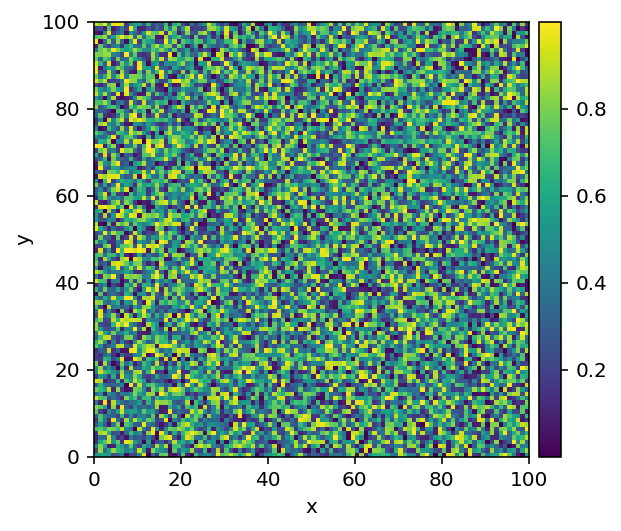

  0%|          | 0/5000.0 [00:00<?, ?it/s]

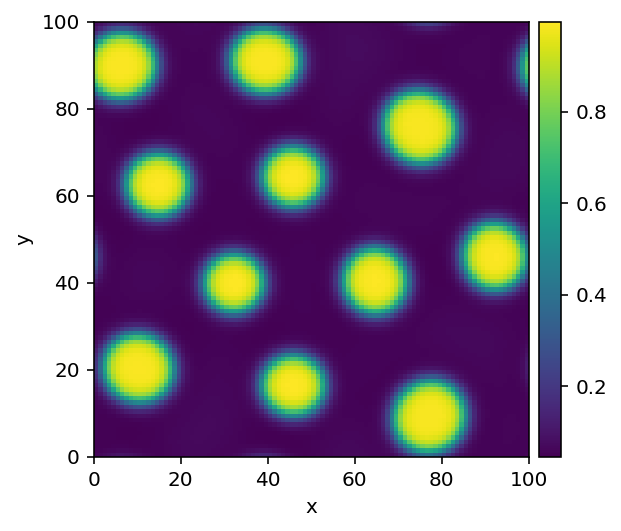

In [12]:
# prepare a random initial state
grid = pde.UnitGrid([100, 100], periodic=True)
initial_state = pde.ScalarField.random_uniform(grid, vmin=0, vmax=1.)
initial_state.plot();

# simulate the dynamics
storage = pde.MemoryStorage()
final_state = eq2.solve(initial_state, t_range=5000, dt=1.e-2, tracker=['progress', storage.tracker(10)])
final_state.plot();

### Solution 4
Units of $D$ are $L^2/T$ and units of $k$ are $1/T$. The length scale is $\ell=\sqrt{D/k}=20$, system size is $L=32$ so its $L~1.5\ell$. For $L=5\ell$ we see multiple droplets of simiilar size with similar spacing.

### Problem 5

In what pattern do the droplets arrange and why?<br>
Not all droplets attain exactly the same size for this simulation time, would they end up at the same size if you simulate infinitely long?

### Solution 5

They arrange in a hexagonal pattern, because it is the closed packing solution in 2D. As a hexagonal pattern does not fit into a quadratic box it is possible that the steady state contains defects and not all droplets attain exactly the same time even for infinite simulation time.

## Droplet size depends on length scale $\ell$

In [13]:
# define the partial differential equation
k = 2.e-2
D = 2
c0 = 0.25
print(np.sqrt(D/k))

eq2 = pde.PDE({'c': f'laplace(2 * c * (1 - c) * (1 - 2*c) - 2*laplace(c)) - {k} * (c - {c0})'})
eq2.expressions

10.0


{'c': '-0.02*c + laplace(2*c*(c - 1)*(2*c - 1) - 2*laplace(c)) + 0.005'}

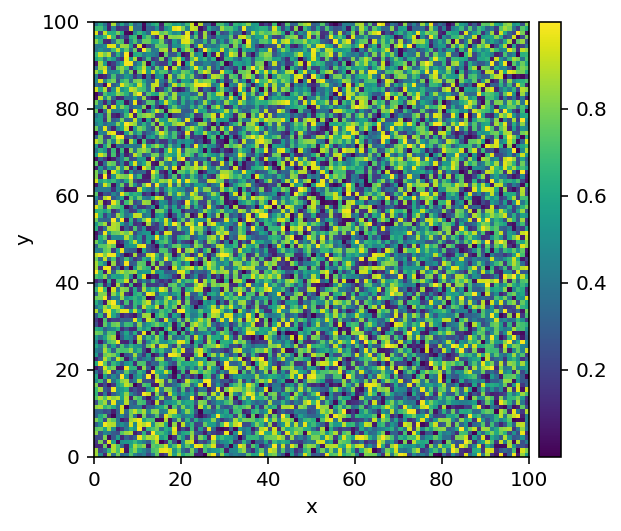

  0%|          | 0/5000.0 [00:00<?, ?it/s]

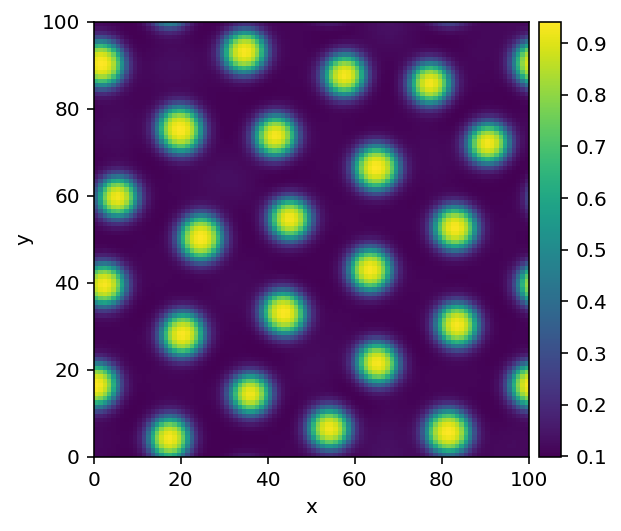

In [14]:
# prepare a random initial state
grid = pde.UnitGrid([100, 100], periodic=True)
initial_state = pde.ScalarField.random_uniform(grid, vmin=0, vmax=1.)
initial_state.plot();

# simulate the dynamics
storage = pde.MemoryStorage()
final_state = eq2.solve(initial_state, t_range=5000, dt=1.e-2, tracker=['progress', storage.tracker(10)])
final_state.plot();

In [15]:
binary = np.where(final_state.data>0.5,1,0)

from scipy.ndimage import measurements
lw, num = measurements.label(binary)

/var/folders/6x/sj3r72314c7bls1njxbxf30h0000gn/T/ipykernel_67508/1371937154.py:4: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  lw, num = measurements.label(binary)


In [16]:
offset = np.array([20*dim if p else 0 for p, dim in zip(grid.periodic, grid.shape)])
pad = np.c_[offset, offset].astype(np.intc)
mask_padded = np.pad(binary, pad, mode="wrap")
assert np.all(mask_padded.shape == np.array(grid.shape) + 2 * offset)

# locate individual clusters in the padded image
labels, num_labels = measurements.label(mask_padded)

indices = range(1, num_labels + 1)

volumes = measurements.sum(mask_padded, labels, index=indices)
radii = 3*volumes**(1/3)/4/np.pi

/var/folders/6x/sj3r72314c7bls1njxbxf30h0000gn/T/ipykernel_67508/959950003.py:7: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  labels, num_labels = measurements.label(mask_padded)
/var/folders/6x/sj3r72314c7bls1njxbxf30h0000gn/T/ipykernel_67508/959950003.py:11: DeprecationWarning: Please use `sum` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  volumes = measurements.sum(mask_padded, labels, index=indices)


66.5708245243129 6.043338439082562
0.9665148227007417 0.03227895349483369


(array([   41.,    41.,    41.,     0.,    41.,     0.,    82., 11767.,
        15047., 11726.]),
 array([12. , 18.4, 24.8, 31.2, 37.6, 44. , 50.4, 56.8, 63.2, 69.6, 76. ]),
 <BarContainer object of 10 artists>)

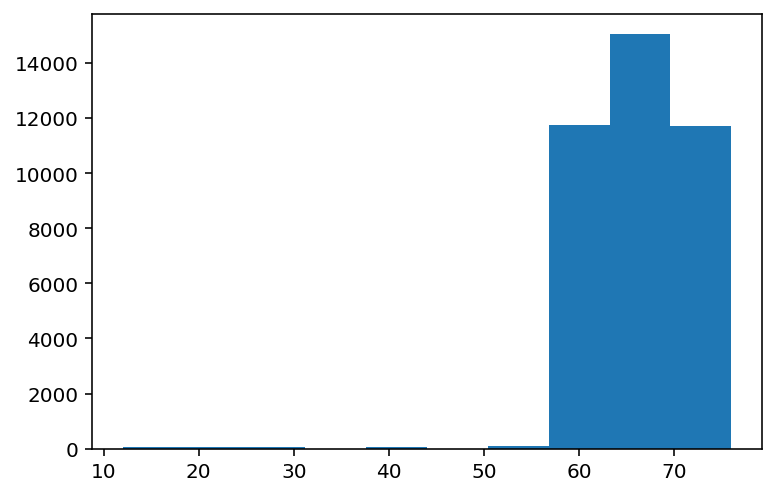

In [17]:
print(np.mean(volumes),np.std(volumes))
print(np.mean(radii),np.std(radii))
plt.hist(volumes)

/var/folders/6x/sj3r72314c7bls1njxbxf30h0000gn/T/ipykernel_67508/919877155.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x,y,f1)


(-0.5, -0.3, -0.5, -0.3)

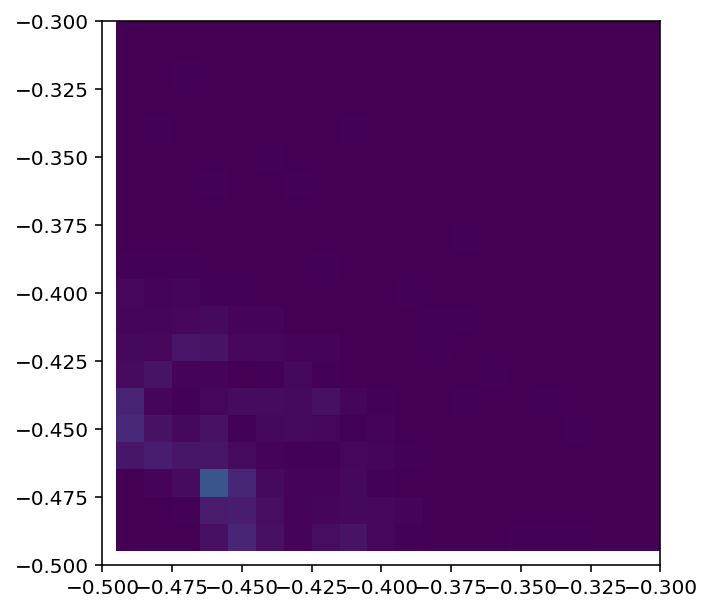

In [18]:
from scipy.fftpack import fft2, fftfreq, fftshift
f1 = np.abs(fftshift(fft2(final_state.data)))
f2 = fft2(final_state.data)
kx, ky = fftfreq(100,1), fftfreq(100,1)
x,y = np.meshgrid(kx,ky)
plt.figure(figsize=(5,5))
plt.pcolormesh(x,y,f1)
plt.axis([-0.5,-0.3,-0.5,-0.3])

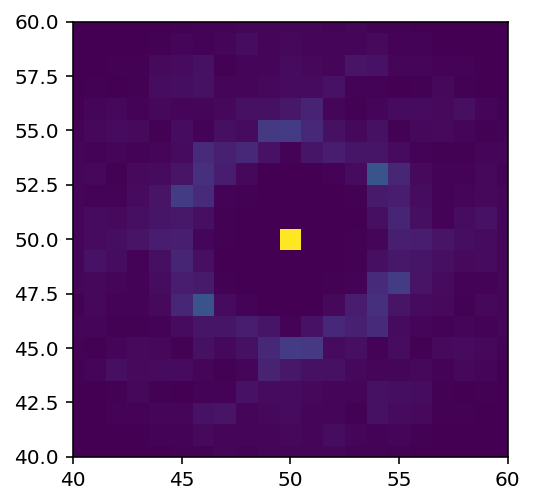

(30.0, 70.0, 0.0, 900.0)

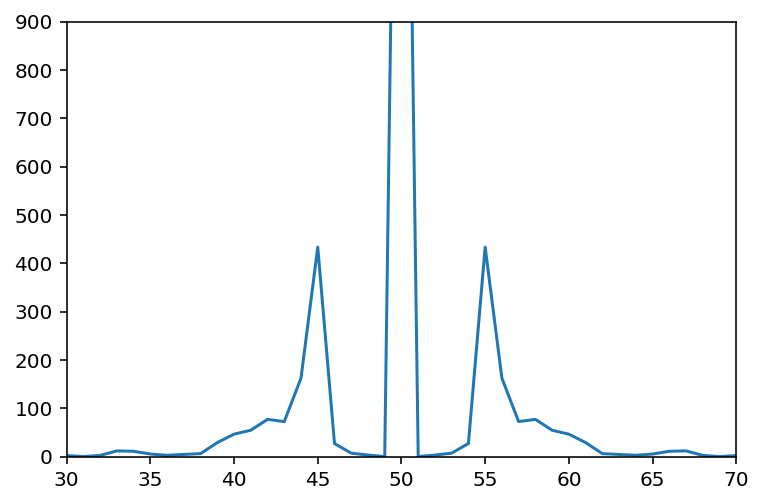

In [19]:
plt.imshow(np.abs(f1))
plt.axis([40,60,40,60])
plt.show()
plt.close()
plt.plot(np.abs(f1)[:,50])
#plt.plot(np.abs(f1)[50])
plt.axis([30,70,0,900])

In [20]:
print(1/0.05)

20.0
